In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import IGtools as igt
import networkx as nx
import os, sys 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook

In [2]:
import igraph as ig

In [3]:
def wedge_closure_boosted_degree(s,t,ss,tt):
    return (s-1) * (np.mean(tt**2)/np.mean(tt)) + (t-1) * (np.mean(ss**2)/np.mean(ss)) 

def wedge_closure_boosted_degree_corrected(s,t,ss,tt):
    return wedge_closure_boosted_degree(s,t,ss,tt) - ((s-1) * (t-1) * (np.mean(tt)-1) * (np.mean(ss) - 1 )) / (np.sum(tt-1))
def second_order_correction(s,t,ss,tt):
    return ((s-1) * (t-1) * (np.mean(tt)-1) * (np.mean(ss) - 1 )) / (np.sum(tt-1))



In [4]:
def plot_results(x,data,norm=None,label=None,marker='s'):
    yy = map(lambda x: np.mean(data[x]), sorted(data.keys()));
    std_yy = map(lambda x: np.std(data[x]), sorted(data.keys()));
    plt.gca()
    if norm==None:
        plt.errorbar(x, np.array(yy), np.array(std_yy), fmt=marker,ms=10,alpha=0.6, label=label);
    else:
        plt.errorbar(x, np.array(yy)/float(norm), np.array(std_yy)/float(norm), fmt=marker,ms=10,alpha=0.6, label=label);
    return;

In [5]:
from scipy.optimize import fsolve, fmin, root
import sympy as sy
from mis_utils import *

# Simulation-driven comparison with IG 

In [6]:
####### analytical functions for Gaussian degree distributions 
def attempt_scipy_func_gauss(x, d,sigma, c):
    return np.abs(x - np.power(1 - ((sigma*sigma*np.log(x)+d)/float(d*x)) * np.exp((d*np.log(x) + 0.5*sigma*sigma*np.power(np.log(x),2))), c-1));


def minimize_gauss_pstar(xs, d, sigma, c):
    vals = map(lambda x: attempt_scipy_func_gauss(x, d, sigma, c), xs);
    x0 = (np.min(vals), xs[np.nanargmin(vals)])
    return x0[1]

def rho_gauss(x,d,sigma,c):
    ed01dp0 = (1 - d - sigma*sigma*np.log(x)) * np.exp(d*np.log(x) + 0.5*sigma*sigma*np.log(x)*np.log(x))
    return (d/c)  * (1 - np.power(x,c/float(c-1))) + (ed01dp0);

def gaussian_prediction(ps,sigmas,xs=None,c=2):
#    if xs == None:
#        xs = np.linspace(0,1,1000);
    import time 
    now = time.time()
    rho_stars_gauss = []
    for i,d in enumerate(ps):
        p_stars_gauss = minimize_gauss_pstar(xs, d , sigmas[i], c);
        rho_stars_gauss.append(rho_gauss(p_stars_gauss, d , sigmas[i], c));
    return rho_stars_gauss;


In [7]:
num_iter = 10;
nN = 50;

new_res_ig = {};
new_av_k_ig = {}
new_n_ig_dict = {}
new_ig_num_edges = {}

In [8]:
import time
from datetime import datetime

import igraph as igg
new_k_min = 1
new_k_max = 10
new_pmin = new_k_min/float(nN);
new_pmax = new_k_max/float(nN);
precision = 10
new_ps = np.linspace(new_pmin,new_pmax,precision);

from scipy.stats import norm

for l,p in tqdm_notebook(enumerate(new_ps)):
    print l, '/', precision, ':', len(new_ps), 'started:', str(datetime.now())
    new_res_ig[p] = []
    new_n_ig_dict[p] = []
    new_ig_num_edges[p] = []
    for it in range(num_iter):
        g = igt.create_ER_bipartite_graph(nN,p) # create ER bipartite graph
        lg = igt.line_graph(g) # create line graph
        ig = igt.interference_graph(lg) # create interference graph
        new_n_ig = ig.number_of_nodes() # compute number of tasks M
        new_n_ig_dict[p].append(new_n_ig); # compute number of tasks M
#         nx.write_gml(ig,'test.gml'); #horrible trick
#         g_igraph = igg.load('test.gml') 
#         new_res_ig[p].append( g_igraph.alpha() )  # empirical/real MIS size
        new_res_ig[p].append( len(nx.maximal_independent_set(ig)))
        new_ig_num_edges[p].append(ig.number_of_edges())

0 / 10 : 10 started: 2019-11-05 16:44:12.869368
1 / 10 : 10 started: 2019-11-05 16:44:12.981865
2 / 10 : 10 started: 2019-11-05 16:44:13.629754
3 / 10 : 10 started: 2019-11-05 16:44:16.461445
4 / 10 : 10 started: 2019-11-05 16:44:22.451985
5 / 10 : 10 started: 2019-11-05 16:44:30.365297
6 / 10 : 10 started: 2019-11-05 16:44:43.113242
7 / 10 : 10 started: 2019-11-05 16:45:02.662927
8 / 10 : 10 started: 2019-11-05 16:45:26.519581
9 / 10 : 10 started: 2019-11-05 16:45:59.577091



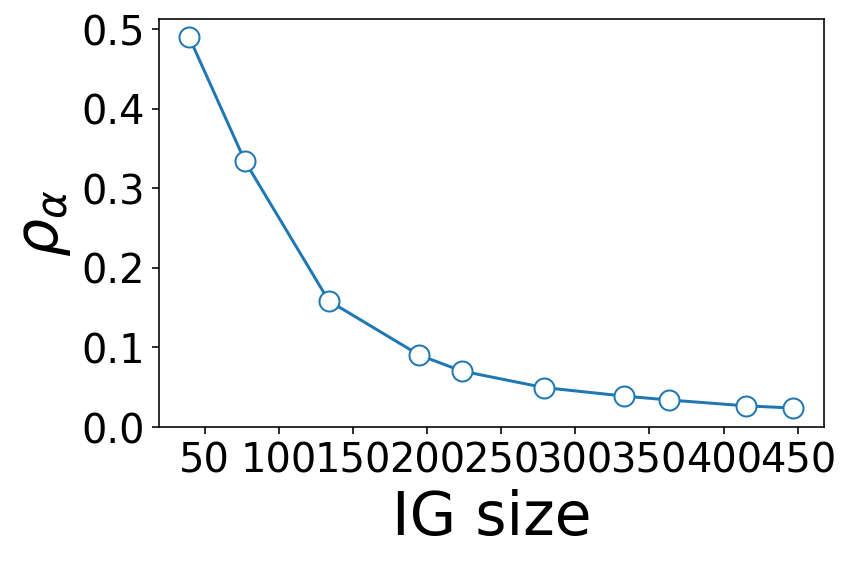

In [9]:
x, y = map(lambda x: np.mean(new_n_ig_dict[x]), new_ps), map(lambda x: np.mean(new_res_ig[x]), new_ps)

plt.plot(np.array(x), np.array(y)/np.array(x),'-o', markerfacecolor='white', ms=10)
# plt.errorbar(np.array(x), np.array(y)/np.array(x), yerr)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel(r'$\rho_\alpha$', fontsize=30)
plt.xlabel(r'IG size', fontsize=30)
plt.tight_layout()

In [21]:
# different degree distribution

import time
from datetime import datetime

import igraph as igg
new_ms = range(2,10)

from scipy.stats import norm
new_res_ig = {};
new_av_k_ig = {}
new_n_ig_dict = {}
new_ig_num_edges = {}

for l,m in tqdm_notebook(enumerate(new_ms)):
    print l, '/', precision, ':', len(new_ms), 'started:', str(datetime.now())
    new_res_ig[m] = []
    new_n_ig_dict[m] = []
    new_ig_num_edges[m] = []
    for it in range(num_iter):
        g = igt.create_BA_bipartite_graph(nN,m)
        lg = igt.line_graph(g) # create line graph
        ig = igt.interference_graph(lg) # create interference graph
        new_n_ig = ig.number_of_nodes() # compute number of tasks M
        new_n_ig_dict[m].append(new_n_ig); # compute number of tasks M
        new_res_ig[m].append( len(nx.maximal_independent_set(ig)))
        new_ig_num_edges[m].append(ig.number_of_edges())

0 / 10 : 8 started: 2019-11-05 17:20:41.482533
1 / 10 : 8 started: 2019-11-05 17:20:46.350429
2 / 10 : 8 started: 2019-11-05 17:20:57.124552
3 / 10 : 8 started: 2019-11-05 17:21:16.111140
4 / 10 : 8 started: 2019-11-05 17:21:44.248346
5 / 10 : 8 started: 2019-11-05 17:22:21.825747
6 / 10 : 8 started: 2019-11-05 17:23:10.505635
7 / 10 : 8 started: 2019-11-05 17:24:08.903263



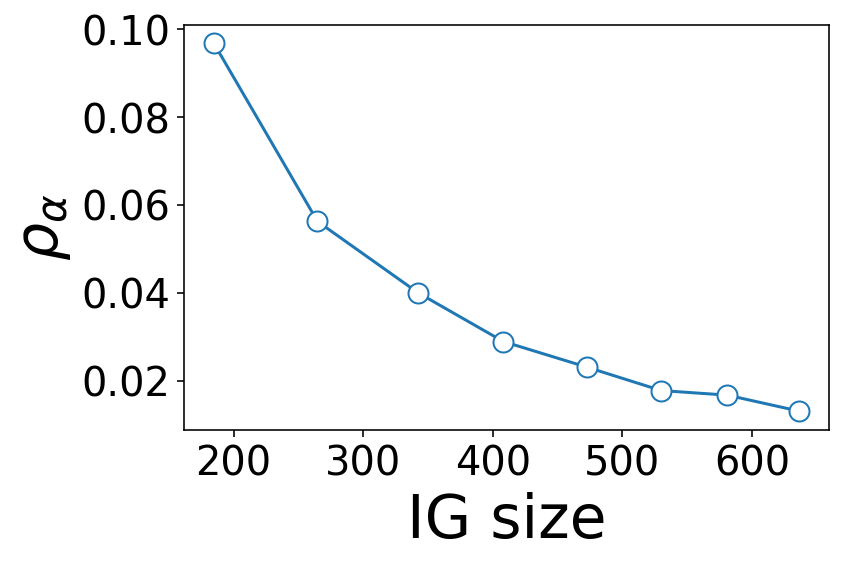

In [23]:
x, y = map(lambda x: np.mean(new_n_ig_dict[x]), new_ms), map(lambda x: np.mean(new_res_ig[x]), new_ms)

plt.plot(np.array(x), np.array(y)/np.array(x),'-o', markerfacecolor='white', ms=10)
# plt.errorbar(np.array(x), np.array(y)/np.array(x), yerr)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel(r'$\rho_\alpha$', fontsize=30)
plt.xlabel(r'IG size', fontsize=30)
plt.tight_layout()

# Fixed density IG

In [24]:
import time
from datetime import datetime

import igraph as igg
p = 0.7; 
ns = list(range(100,2000,300))

from scipy.stats import norm

new_res_ig = {};
new_av_k_ig = {}
new_n_ig_dict = {}
new_ig_num_edges = {}

for l, n in tqdm_notebook(enumerate(ns)):
    new_res_ig[n] = []
    new_n_ig_dict[n] = []
    new_ig_num_edges[n] = []
    for it in range(num_iter):
        ig = nx.erdos_renyi_graph(n,p) # create ER bipartite graph
        new_n_ig = ig.number_of_nodes() # compute number of tasks M
        new_n_ig_dict[n].append(new_n_ig); # compute number of tasks M
        new_res_ig[n].append( len(nx.maximal_independent_set(ig)))
        new_ig_num_edges[n].append(ig.number_of_edges())

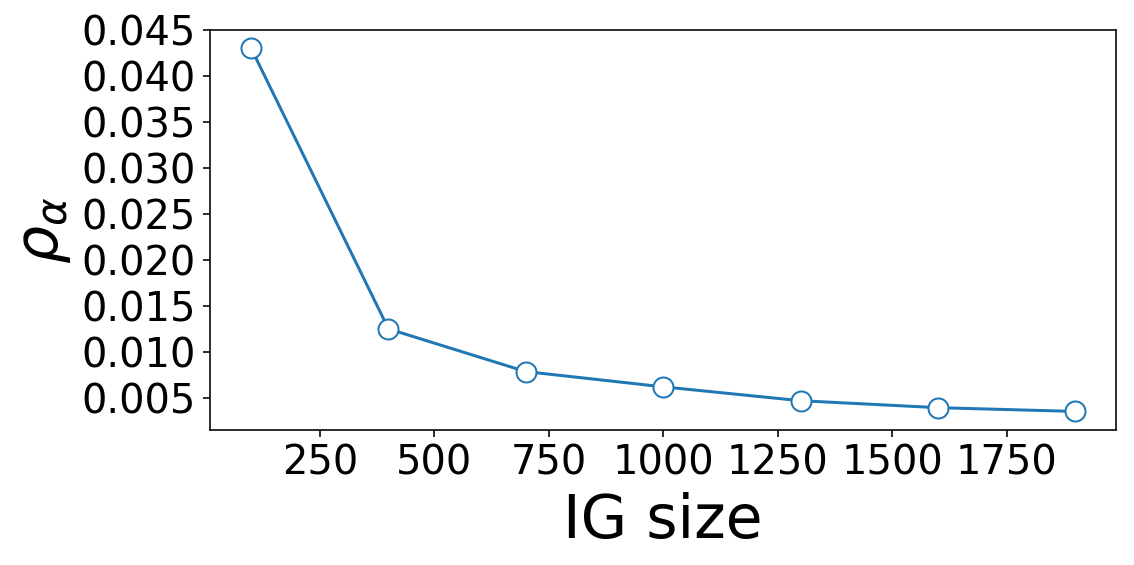

In [28]:
x, y = map(lambda x: np.mean(new_n_ig_dict[x]), ns), map(lambda x: np.mean(new_res_ig[x]), ns)

plt.figure(figsize=(8,4))
plt.plot(np.array(x), np.array(y)/np.array(x),'-o', markerfacecolor='white', ms=10)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel(r'$\rho_\alpha$', fontsize=30)
plt.xlabel(r'IG size', fontsize=30)
plt.tight_layout()
plt.savefig('../submission/natphys-rebuttal/plots/size-scaling-fixed-density-MIS-simple-ER.pdf')

# multiple fixed densities IG

In [75]:
import time
from datetime import datetime

import igraph as igg
ns = list(range(100,2000,300))

from scipy.stats import norm

new_res_ig = {};
new_av_k_ig = {}
new_n_ig_dict = {}
new_ig_num_edges = {}
ps = np.linspace(0.1,.8, 5);

for p in tqdm_notebook(ps):
    new_res_ig[p] = {}
    new_n_ig_dict[p] = {}
    new_ig_num_edges[p] = {}
    for l, n in tqdm_notebook(enumerate(ns)):
        new_res_ig[p][n] = []
        new_n_ig_dict[p][n] = []
        new_ig_num_edges[p][n] = []
        for it in range(num_iter):
            ig = nx.erdos_renyi_graph(n,p) # create ER bipartite graph
            new_n_ig = ig.number_of_nodes() # compute number of tasks M
            new_n_ig_dict[p][n].append(new_n_ig); # compute number of tasks M
            new_res_ig[p][n].append( len(nx.maximal_independent_set(ig)))
            new_ig_num_edges[p][n].append(ig.number_of_edges())

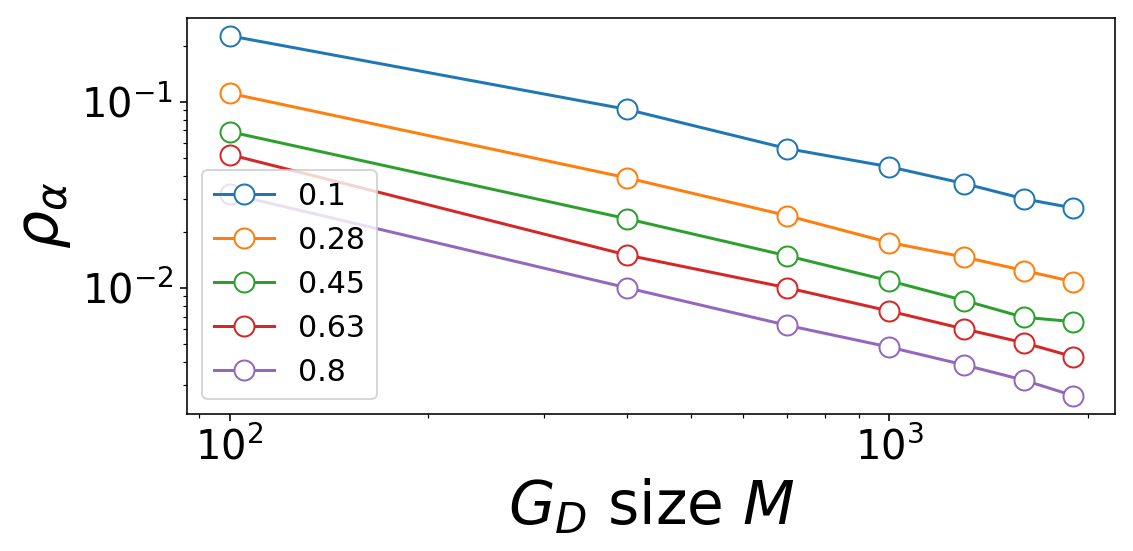

In [76]:

fig = plt.figure(figsize=(8,4))

for p in ps:
    x, y = map(lambda x: np.mean(new_n_ig_dict[p][x]), ns), map(lambda x: np.mean(new_res_ig[p][x]), ns)
    plt.plot(np.array(x), np.array(y)/np.array(x),'-o', markerfacecolor='white', ms=10, label = round(p,2))
    
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel(r'$\rho_\alpha$', fontsize=30)
plt.xlabel(r'$G_D$ size $M$', fontsize=30)
plt.legend(fontsize=15)
plt.yscale('log')
plt.xscale('log')
plt.tight_layout()
plt.savefig('../submission/natphys-rebuttal/plots/size-scaling-fixed-density-MIS-simple-ER-log.pdf')

# Fixed  Average Degree 

In [67]:
import time
from datetime import datetime

import igraph as igg
ns = list(range(100,2000,300))

from scipy.stats import norm

new_res_ig = {};
new_av_k_ig = {}
new_n_ig_dict = {}
new_ig_num_edges = {}

ps = range(3, 10, 2)

for p in tqdm_notebook(ps):
    new_res_ig[p] = {}
    new_n_ig_dict[p] = {}
    new_ig_num_edges[p] = {}
    for l, n in tqdm_notebook(enumerate(ns)):
        new_res_ig[p][n] = []
        new_n_ig_dict[p][n] = []
        new_ig_num_edges[p][n] = []
        for it in range(num_iter):
            ig = nx.erdos_renyi_graph(n, p/float(n)) # create ER bipartite graph
            new_n_ig = ig.number_of_nodes() # compute number of tasks M
            new_n_ig_dict[p][n].append(new_n_ig); # compute number of tasks M
            new_res_ig[p][n].append( len(nx.maximal_independent_set(ig)))
            new_ig_num_edges[p][n].append(ig.number_of_edges())

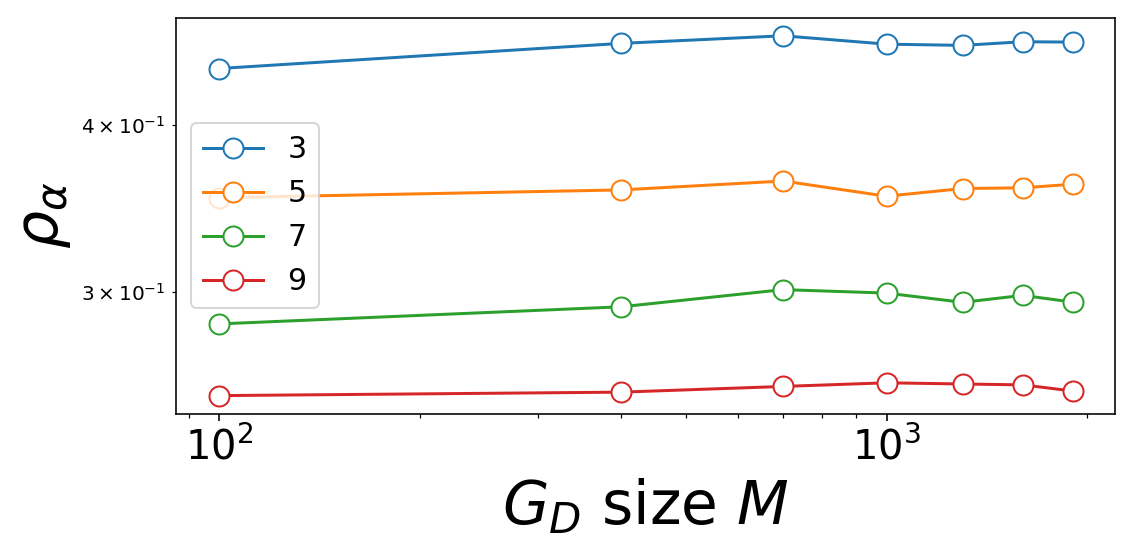

In [74]:

fig = plt.figure(figsize=(8,4))

for p in ps:
    x, y = map(lambda x: np.mean(new_n_ig_dict[p][x]), ns), map(lambda x: np.mean(new_res_ig[p][x]), ns)
    plt.plot(np.array(x), np.array(y)/np.array(x),'-o', markerfacecolor='white', ms=10, label = p)
    
plt.ylabel(r'$\rho_\alpha$', fontsize=30)
plt.xlabel(r'$G_D$ size $M$', fontsize=30)
plt.legend(fontsize=15)
plt.yscale('log')
plt.xscale('log')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.tight_layout()
plt.savefig('../submission/natphys-rebuttal/plots/size-scaling-fixed-density-MIS-simple-ER-log-fixed-deg.pdf')

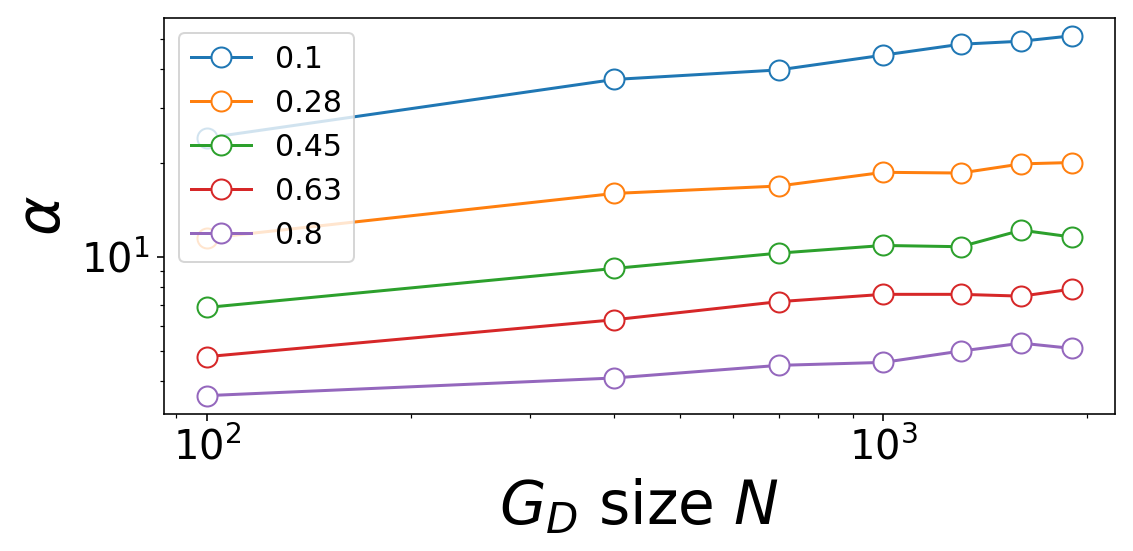

In [25]:

fig = plt.figure(figsize=(8,4))

for p in ps:
    x, y = map(lambda x: np.mean(new_n_ig_dict[p][x]), ns), map(lambda x: np.mean(new_res_ig[p][x]), ns)
    plt.plot(np.array(x), np.array(y),'-o', markerfacecolor='white', ms=10, label = round(p,2))
    
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel(r'$\alpha$', fontsize=30)
plt.xlabel(r'$G_D$ size $N$', fontsize=30)
plt.legend(fontsize=15)
plt.yscale('log')
plt.xscale('log')
plt.tight_layout()
# plt.savefig('../submission/natphys-rebuttal/plots/size-scaling-fixed-density-MIS-simple-ER-log.pdf')

# BA fixed av degree 

In [87]:
import time
from datetime import datetime

import igraph as igg
ns = list(range(100,2000,300))

from scipy.stats import norm

new_res_ig = {};
new_av_k_ig = {}
new_n_ig_dict = {}
new_ig_num_edges = {}
ms = range(2,7)

for m in tqdm_notebook(ms):
    new_res_ig[m] = {}
    new_n_ig_dict[m] = {}
    new_ig_num_edges[m] = {}
    for l, n in tqdm_notebook(enumerate(ns)):
        new_res_ig[m][n] = []
        new_n_ig_dict[m][n] = []
        new_ig_num_edges[m][n] = []
        for it in range(num_iter):
            ig = nx.barabasi_albert_graph(n,m) # create ER bipartite graph
            new_n_ig = ig.number_of_nodes() # compute number of tasks M
            new_n_ig_dict[m][n].append(new_n_ig); # compute number of tasks M
            new_res_ig[m][n].append( len(nx.maximal_independent_set(ig)));
            new_ig_num_edges[m][n].append(ig.number_of_edges());

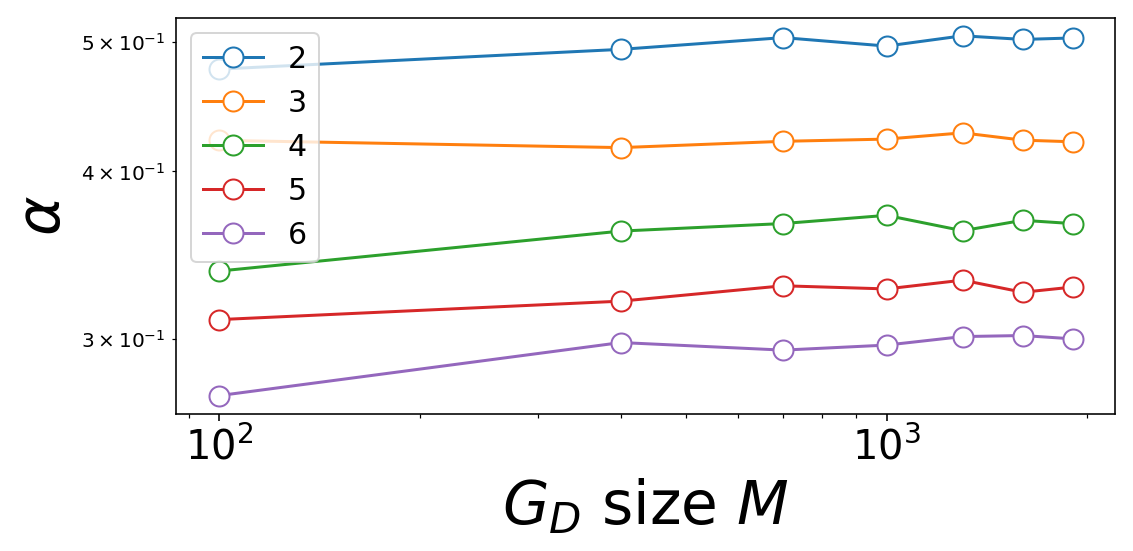

In [88]:

fig = plt.figure(figsize=(8,4))

for m in ms:
    x, y = map(lambda x: np.mean(new_n_ig_dict[m][x]), ns), map(lambda x: np.mean(new_res_ig[m][x]), ns)
    plt.plot(np.array(x), np.array(y)/np.array(x),'-o', markerfacecolor='white', ms=10, label = m)
    
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel(r'$\alpha$', fontsize=30)
plt.xlabel(r'$G_D$ size $M$', fontsize=30)
plt.legend(fontsize=15)
plt.yscale('log')
plt.xscale('log')
plt.tight_layout()
plt.savefig('../submission/natphys-rebuttal/plots/size-scaling-fixed-density-MIS-simple-BA-log-deg.pdf')

# BA with fixed density

In [83]:
import time
from datetime import datetime

import igraph as igg
ns = list(range(100,2000,300))

from scipy.stats import norm

new_res_ig = {};
new_av_k_ig = {}
new_n_ig_dict = {}
new_ig_num_edges = {}
rhos = [0.02, .05, .07, .09]

for m in tqdm_notebook(rhos):
    new_res_ig[m] = {}
    new_n_ig_dict[m] = {}
    new_ig_num_edges[m] = {}
    for l, n in tqdm_notebook(enumerate(ns)):
        new_res_ig[m][n] = []
        new_n_ig_dict[m][n] = []
        new_ig_num_edges[m][n] = []
        for it in range(num_iter):
            ig = nx.barabasi_albert_graph(n,int(m*n)) # create ER bipartite graph
            new_n_ig = ig.number_of_nodes() # compute number of tasks M
            new_n_ig_dict[m][n].append(new_n_ig); # compute number of tasks M
            new_res_ig[m][n].append( len(nx.maximal_independent_set(ig)));
            new_ig_num_edges[m][n].append(ig.number_of_edges());

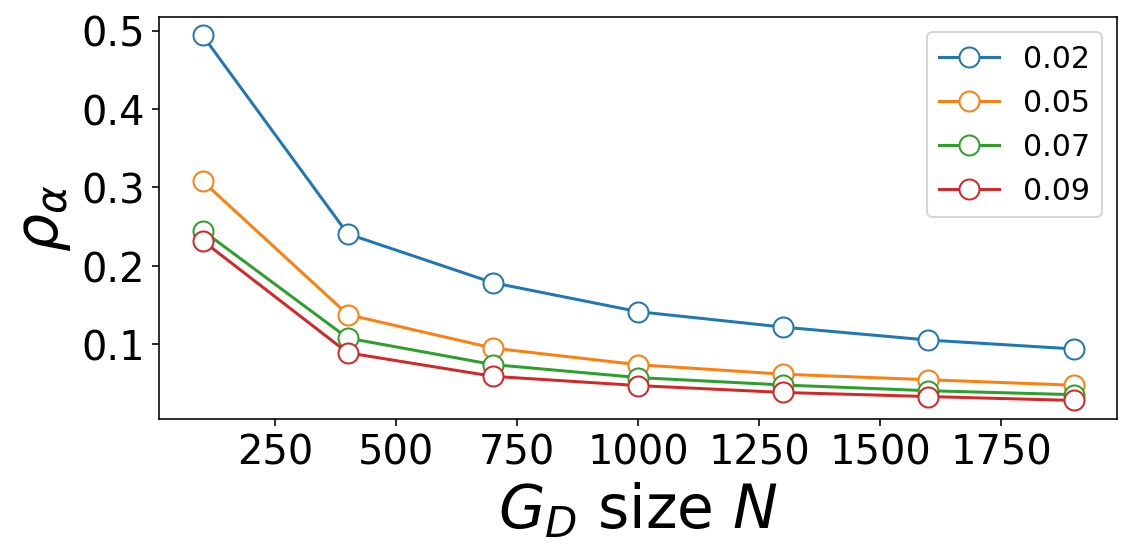

In [86]:

fig = plt.figure(figsize=(8,4))

for m in rhos:
    x, y = map(lambda x: np.mean(new_n_ig_dict[m][x]), ns), map(lambda x: np.mean(new_res_ig[m][x]), ns)
    plt.plot(np.array(x), np.array(y)/np.array(x),'-o', markerfacecolor='white', ms=10, label = m)
    
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel(r'$\rho_\alpha$', fontsize=30)
plt.xlabel(r'$G_D$ size $N$', fontsize=30)
plt.legend(fontsize=15)
# plt.yscale('log')
# plt.xscale('log')
plt.tight_layout()
plt.savefig('../submission/natphys-rebuttal/plots/size-scaling-fixed-density-MIS-simple-BA-log.pdf')

# Random regular graphs fixed density

In [62]:
import time
from datetime import datetime

import igraph as igg
ns = list(range(100,2000,300))

from scipy.stats import norm

new_res_ig = {};
new_av_k_ig = {}
new_n_ig_dict = {}
new_ig_num_edges = {}
ps = np.array(range(2,10,2));
n0 = 100;

for p in tqdm_notebook(ps):
    new_res_ig[p] = {}
    new_n_ig_dict[p] = {}
    new_ig_num_edges[p] = {}
    for l, n in tqdm_notebook(enumerate(ns)):
        new_res_ig[p][n] = []
        new_n_ig_dict[p][n] = []
        new_ig_num_edges[p][n] = []
        for it in range(num_iter):
            ig = nx.random_regular_graph(,n0*p) # create ER bipartite graph
            new_n_ig = ig.number_of_nodes() # compute number of tasks M
            new_n_ig_dict[p][n].append(new_n_ig); # compute number of tasks M
            new_res_ig[p][n].append( len(nx.maximal_independent_set(ig)))
            new_ig_num_edges[p][n].append(ig.number_of_edges())

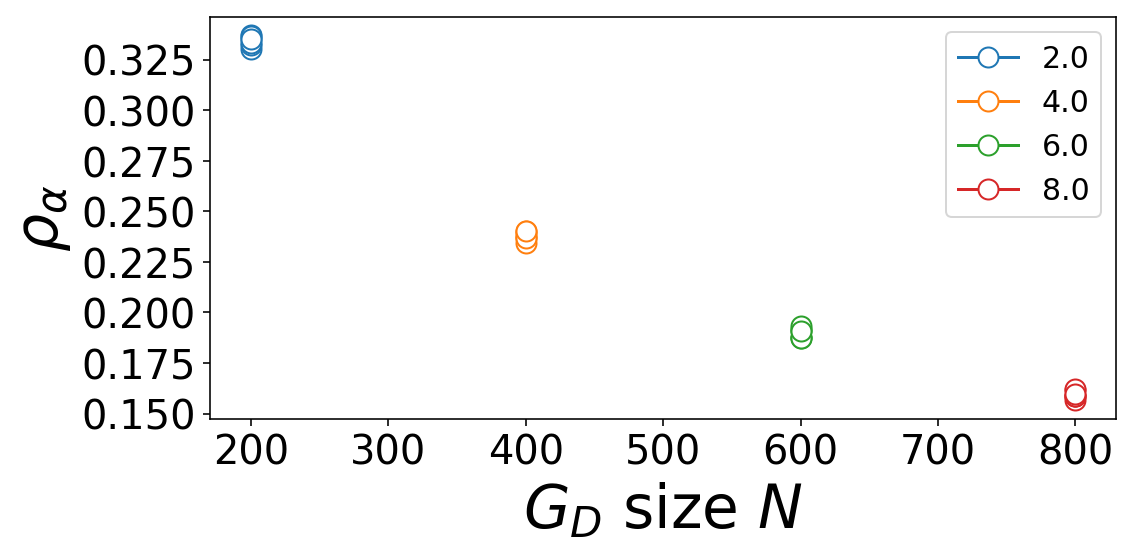

In [64]:

fig = plt.figure(figsize=(8,4))

for p in ps:
    x, y = map(lambda x: np.mean(new_n_ig_dict[p][x]), ns), map(lambda x: np.mean(new_res_ig[p][x]), ns)
    plt.plot(np.array(x), np.array(y)/np.array(x),'-o', markerfacecolor='white', ms=10, label = round(p,2))
    
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel(r'$\rho_\alpha$', fontsize=30)
plt.xlabel(r'$G_D$ size $N$', fontsize=30)
plt.legend(fontsize=15)
# plt.yscale('log')
# plt.xscale('log')
plt.tight_layout()
# plt.savefig('../submission/natphys-rebuttal/plots/size-scaling-fixed-density-MIS-simple-ER-log.pdf')

In [59]:
import time
from datetime import datetime

import igraph as igg
ns = list(range(10,50,5))

from scipy.stats import norm

new_res_ig = {};
new_av_k_ig = {}
new_n_ig_dict = {}
new_ig_num_edges = {}
ps = np.array(range(2,10,2));

for p in tqdm_notebook(ps):
    new_res_ig[p] = {}
    new_n_ig_dict[p] = {}
    new_ig_num_edges[p] = {}
    for l, n in tqdm_notebook(enumerate(ns)):
        new_res_ig[p][n] = []
        new_n_ig_dict[p][n] = []
        new_ig_num_edges[p][n] = []
        for it in range(num_iter):
#             ig = nx.random_regular_graph(p,n) # create ER bipartite graph
            ig = igt.create_configuration_model_graph([p]*n)
            ig = igt.line_graph(ig);
            ig = igt.interference_graph(ig);
            new_n_ig = ig.number_of_nodes() # compute number of tasks M
            new_n_ig_dict[p][n].append(new_n_ig); # compute number of tasks M
            new_res_ig[p][n].append( len(nx.maximal_independent_set(ig)))
            new_ig_num_edges[p][n].append(ig.number_of_edges())

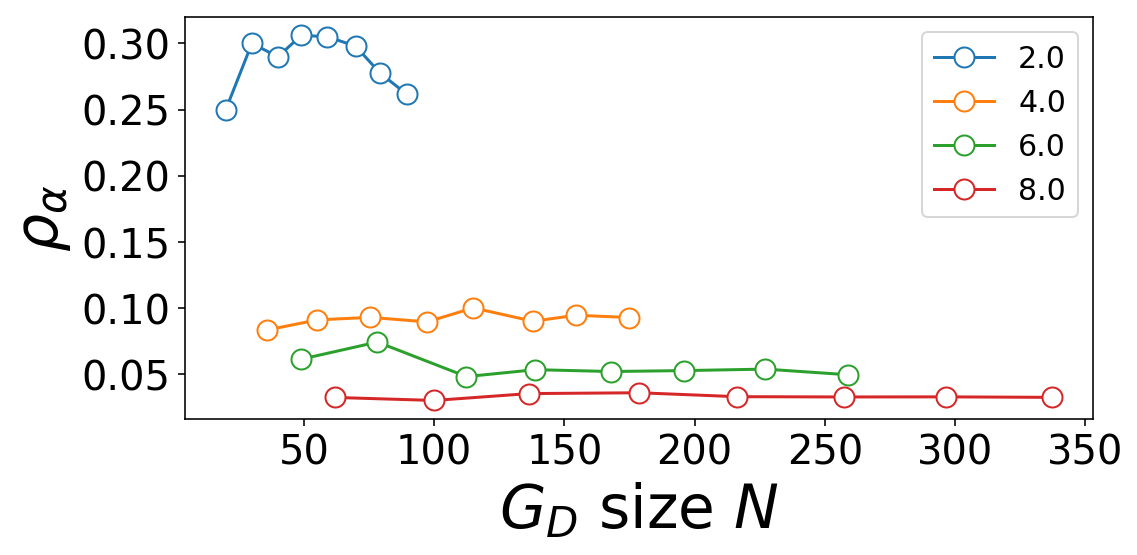

In [60]:

fig = plt.figure(figsize=(8,4))

for p in ps:
    x, y = map(lambda x: np.mean(new_n_ig_dict[p][x]), ns), map(lambda x: np.mean(new_res_ig[p][x]), ns)
    plt.plot(np.array(x), np.array(y)/np.array(x),'-o', markerfacecolor='white', ms=10, label = round(p,2))
    
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel(r'$\rho_\alpha$', fontsize=30)
plt.xlabel(r'$G_D$ size $N$', fontsize=30)
plt.legend(fontsize=15)
# plt.yscale('log')
# plt.xscale('log')
plt.tight_layout()
# plt.savefig('../submission/natphys-rebuttal/plots/size-scaling-fixed-density-MIS-simple-ER-log.pdf')

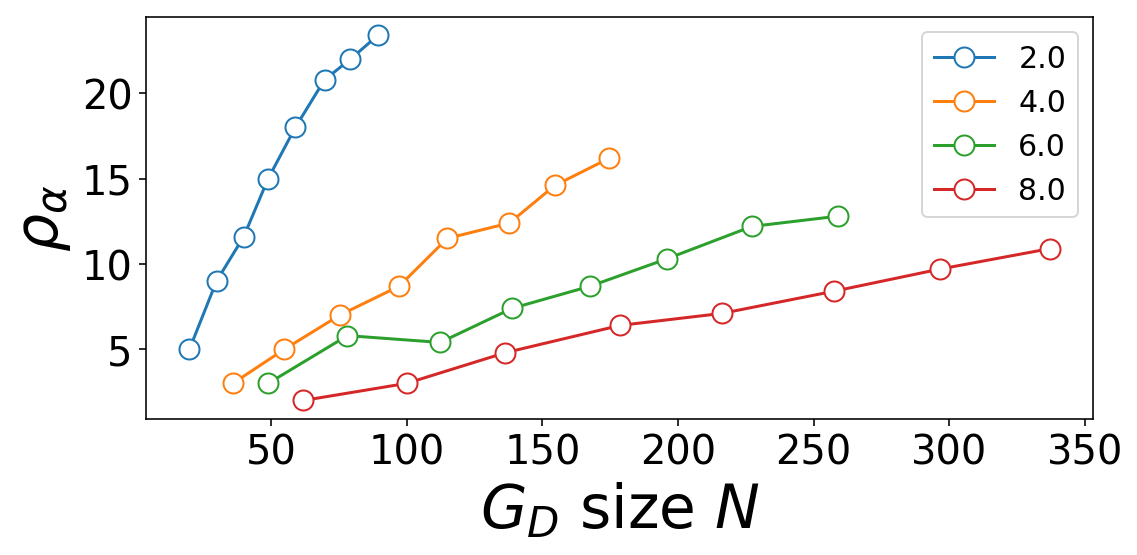

In [61]:

fig = plt.figure(figsize=(8,4))

for p in ps:
    x, y = map(lambda x: np.mean(new_n_ig_dict[p][x]), ns), map(lambda x: np.mean(new_res_ig[p][x]), ns)
    plt.plot(np.array(x), np.array(y),'-o', markerfacecolor='white', ms=10, label = round(p,2))
    
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel(r'$\rho_\alpha$', fontsize=30)
plt.xlabel(r'$G_D$ size $N$', fontsize=30)
plt.legend(fontsize=15)
# plt.yscale('log')
# plt.xscale('log')
plt.tight_layout()
# plt.savefig('../submission/natphys-rebuttal/plots/size-scaling-fixed-density-MIS-simple-ER-log.pdf')